# 1. Projekt bemutatása

  Ez a projekt egy senitmentanalysis modellt, ami képes különböző szövegek  azonosítására. Python és a Transformers könyvtár segítségével készült. A modellt egy BERT-alapú előre betanított modell finomhangolásával hoztam létre. Az adatokat a Kaggle-ről származó Reddit sentimentanalysis datasetet használtam fel.

# 2. Implementáció bemutatása


2.1. Szükséges csomagok telepítése


In [18]:
!pip install datasets
!pip install transformers[torch]
!pip install accelerate
!pip install accelerate -U
!pip install datasets transformers accelerate -U
!pip install river
!pip install datasets transformers[torch] accelerate
!pip install datasets transformers[torch] accelerate river


2.2. Adatok beolvasása és előkészítése


In [25]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset
import torch

# Adatok beolvasása, kódolási hibák kezelése
file_df = pd.read_csv("file.csv", delimiter=';')

# Ellenőrizzük az oszlopok nevét és szükség esetén nevezzük át
file_df = file_df.rename(columns={'text_column_name': 'text', 'label_column_name': 'label'})

# Bemenetek és címkék listába konvertálása
texts = file_df['text'].tolist()
labels = file_df['label'].tolist()

# Ellenőrizzük, hogy a címkék numerikusak-e
file_df['label'] = pd.Categorical(file_df['label']).codes

print("Oszlopok a fajlban:", file_df.columns)


Oszlopok a fajlban: Index(['text', 'label'], dtype='object')


2.3. Tokenizer és modell betöltése


In [26]:
# Tokenizer és modell betöltése
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(labels)))

# Tokenek előkészítése
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Adatok dataset formátumba konvertálása
dataset = Dataset.from_pandas(file_df)
dataset = dataset.map(tokenize_function, batched=True)
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/497 [00:00<?, ? examples/s]

2.4. Train és test set-ek létrehozása


In [27]:
# Train és test set-ek létrehozása
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']



2.5. TrainingArguments beállítása


In [28]:
# TrainingArguments beállítása
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)



2.6. Trainer betanítása


In [29]:
# Trainer inicializálása és betanítása
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

trainer.train()


Step,Training Loss
10,1.118100
20,1.115200
30,1.119900
40,1.103800
50,1.036800
60,1.058700
70,1.018300
80,1.054500
90,1.024600
100,1.038800


TrainOutput(global_step=100, training_loss=1.0688799571990968, metrics={'train_runtime': 68.5585, 'train_samples_per_second': 11.581, 'train_steps_per_second': 1.459, 'total_flos': 208912053676032.0, 'train_loss': 1.0688799571990968, 'epoch': 2.0})

# 3. Predikciók készítése


In [30]:
# Betanított modell használata predikciók készítésére
predictions = trainer.predict(eval_dataset)

# Predikciók kiíratása
print(predictions.predictions)


[[ 0.03489438  0.25777423  0.09657621]
 [-0.03624586 -0.31042835  0.04935791]
 [-0.17034543  0.38780117  0.10995721]
 [-0.2520443   0.61657333  0.1553888 ]
 [-0.09662259  0.38895118 -0.16880888]
 [ 0.0072524   0.07609134 -0.4917571 ]
 [-0.29842523  0.44909853  0.27114975]
 [ 0.02388227 -0.28009903 -0.5597314 ]
 [-0.21784224  0.37596396 -0.17099477]
 [-0.38623402  0.31869084  0.39692706]
 [-0.04192339  0.11979488 -0.00884493]
 [-0.26182342 -0.00536479  0.07685855]
 [-0.12991217  0.3668162   0.19184075]
 [-0.023553    0.2690007  -0.15150869]
 [-0.42751467  0.67439306  0.22440603]
 [-0.24904278  0.24456333  0.25322545]
 [-0.0552945   0.05608856 -0.41094202]
 [-0.2536995   0.26092738  0.2013885 ]
 [-0.36428842  0.55677503  0.3091787 ]
 [-0.07126946  0.03434482 -0.3655482 ]
 [-0.21280932  0.21676336 -0.2542063 ]
 [-0.44010806  0.40581107  0.52802616]
 [-0.19792639  0.6612504  -0.0182429 ]
 [-0.09289445  0.22479174  0.02858325]
 [-0.06167598 -0.22123533 -0.19441143]
 [-0.24113894  0.3944208 

# 4. Teljesítmény értékelése


In [31]:
# Értékelés a teszt adatokon
results = trainer.evaluate(eval_dataset)

# Eredmények kiíratása
print(results)


{'eval_loss': 1.0023516416549683, 'eval_runtime': 2.6766, 'eval_samples_per_second': 37.361, 'eval_steps_per_second': 4.857, 'epoch': 2.0}


# 5. Modell mentése


In [33]:
# Modell mentése
trainer.save_model("./saved_model")


# 6. Modell kipróbálása


In [36]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer

# Modell elérési útjának meghatározása
model_path = "./saved_model"

# Modell betöltése
model = BertForSequenceClassification.from_pretrained(model_path)

# Tokenizátor betöltése
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Teszt bemenet
test_sentence = "Macko papa love his little bear"

# Input előkészítése és predikciók végrehajtása
inputs = tokenizer(test_sentence, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits

# Logitok Softmax transzformációja
probabilities = torch.nn.functional.softmax(logits, dim=1)

# Predikciók feldolgozása és kimenet megjelenítése
predicted_class = torch.argmax(probabilities, dim=1).item()
class_labels = ["negative", "neutral", "positive"]  # Ez a te osztálycímke listád, aminek az osztályok megfelelnek

predicted_label = class_labels[predicted_class]

print(f"Predicted class: {predicted_label}")


Predicted class: positive


# 7. KPI-ok kialakítása a monitorozás érdekében


Drift detektálás ADWIN használatával


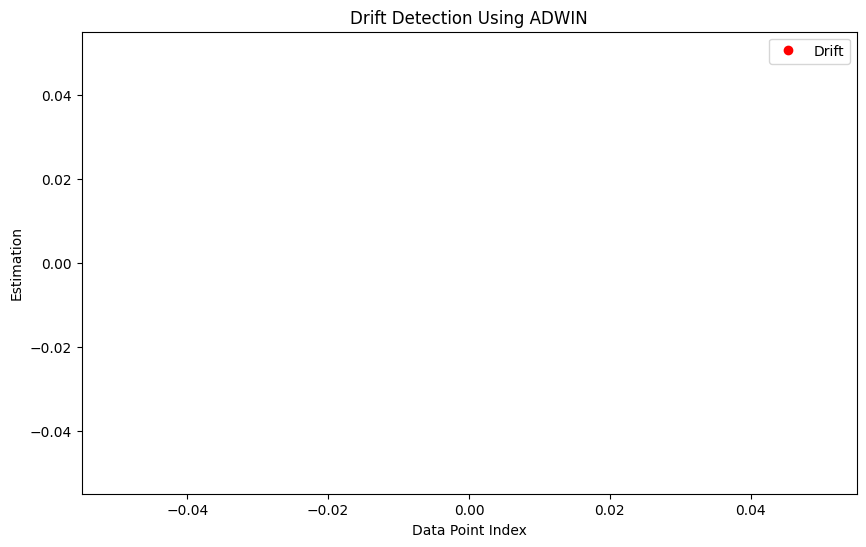

In [37]:
import matplotlib.pyplot as plt
from river import datasets, drift

# Adatbázis betöltése
dataset = datasets.Phishing()

# Drift detektor inicializálása
adwin = drift.ADWIN()

drift_points = []

# Adatok feldolgozása és drift pontok azonosítása
for i, (x, y) in enumerate(dataset):
    adwin.update(y)
    if adwin.drift_detected:
        drift_points.append(i)

# Drift pontok megjelenítése
plt.figure(figsize=(10, 6))
plt.plot(drift_points, [adwin.estimation for _ in drift_points], 'ro', label='Drift')
plt.title('Drift Detection Using ADWIN')
plt.xlabel('Data Point Index')
plt.ylabel('Estimation')
plt.legend()
plt.show()


Drift detektálás Page-Hinkley használatával


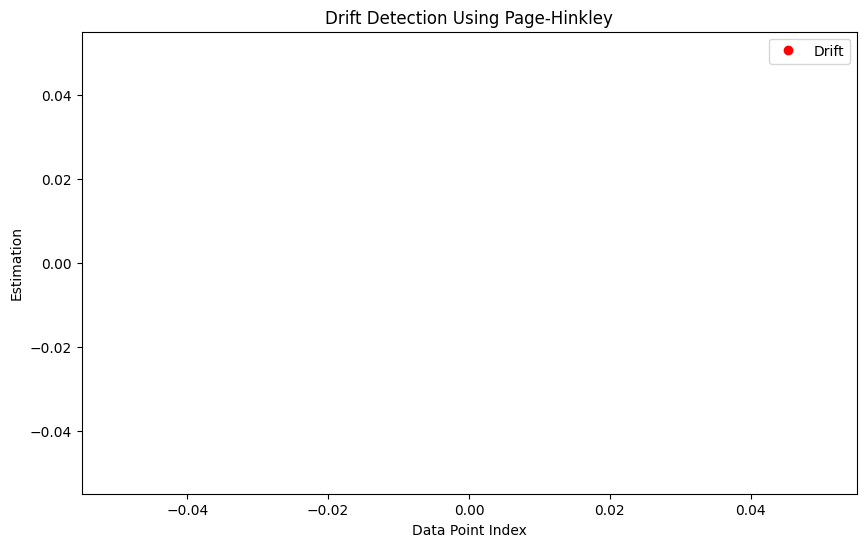

In [38]:
import matplotlib.pyplot as plt
from river import datasets, drift

# Adatbázis betöltése
dataset = datasets.Phishing()

# Drift detektor inicializálása
ph = drift.PageHinkley()

drift_points = []

# Adatok feldolgozása és drift pontok azonosítása
for i, (x, y) in enumerate(dataset):
    ph.update(y)
    if ph.drift_detected:
        drift_points.append(i)

# Drift pontok megjelenítése
plt.figure(figsize=(10, 6))
plt.plot(drift_points, [ph.estimation for _ in drift_points], 'ro', label='Drift')
plt.title('Drift Detection Using Page-Hinkley')
plt.xlabel('Data Point Index')
plt.ylabel('Estimation')
plt.legend()
plt.show()
